This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


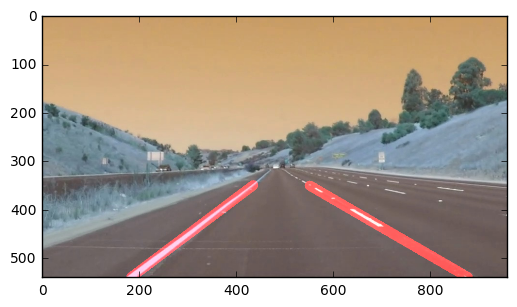

In [67]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg', cv2.IMREAD_COLOR)

#grayscale the image
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(350, 350), (550, 350), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Use polyfit to draw lines on a blank image
left_x_arr = []
left_y_arr = []
right_x_arr = []
right_y_arr = []
for line in lines:
    for x1,y1,x2,y2 in line:
        slope = float((y2-y1)/(x2-x1))

        if not np.isnan(slope) or np.isinf(slope) or (slope == 0):
            if (slope > -1) and (slope < -0.6):
                left_x_arr.append(x1)
                left_x_arr.append(x2)
                left_y_arr.append(y1)
                left_y_arr.append(y2)
            if (slope > 0.2) and (slope < 1.5) :
                right_x_arr.append(x1)
                right_x_arr.append(x2)
                right_y_arr.append(y1)
                right_y_arr.append(y2)

left_fit_para = np.polyfit(left_x_arr, left_y_arr, 1)
right_fit_para = np.polyfit(right_x_arr, right_y_arr, 1)

left_y_min = min(left_y_arr)
right_y_min = min(right_y_arr)

left_top_point = ((int)((left_y_min - left_fit_para[1])/left_fit_para[0]), left_y_min)
left_bottom_point = ((int)((image.shape[0] - left_fit_para[1])/left_fit_para[0]), image.shape[0])
cv2.line(line_image, left_top_point, left_bottom_point, (255, 0, 0), 20)

right_top_point = ((int)((right_y_min - right_fit_para[1])/right_fit_para[0]), right_y_min)
right_bottom_point = ((int)((image.shape[0] - right_fit_para[1])/right_fit_para[0]), image.shape[0])
cv2.line(line_image, right_top_point, right_bottom_point, (255, 0, 0), 20)

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(line_image, 1, image, 1, 0)

print('This image is:', type(lines_edges), 'with dimensions:', image.shape)
plt.imshow(lines_edges)